# Identificação de Outliers em Rótulos de Cerveja
Alunos:
* Luís Felipe Corrêa Ortolan, 759375
* Marco Antônio Bernardi Grivol, 758619

# Carregando as Imagens

In [1]:
import cv2
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from projeto_helper import BeerClassification
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\Skol'

In [2]:
ids = ['0', '1', '2', '3'] # conjuntos para análise
bc = BeerClassification(PATH, ids)
# for i, label in enumerate(bc.labels):
#     print(i, label)
len(bc.imgs)

600

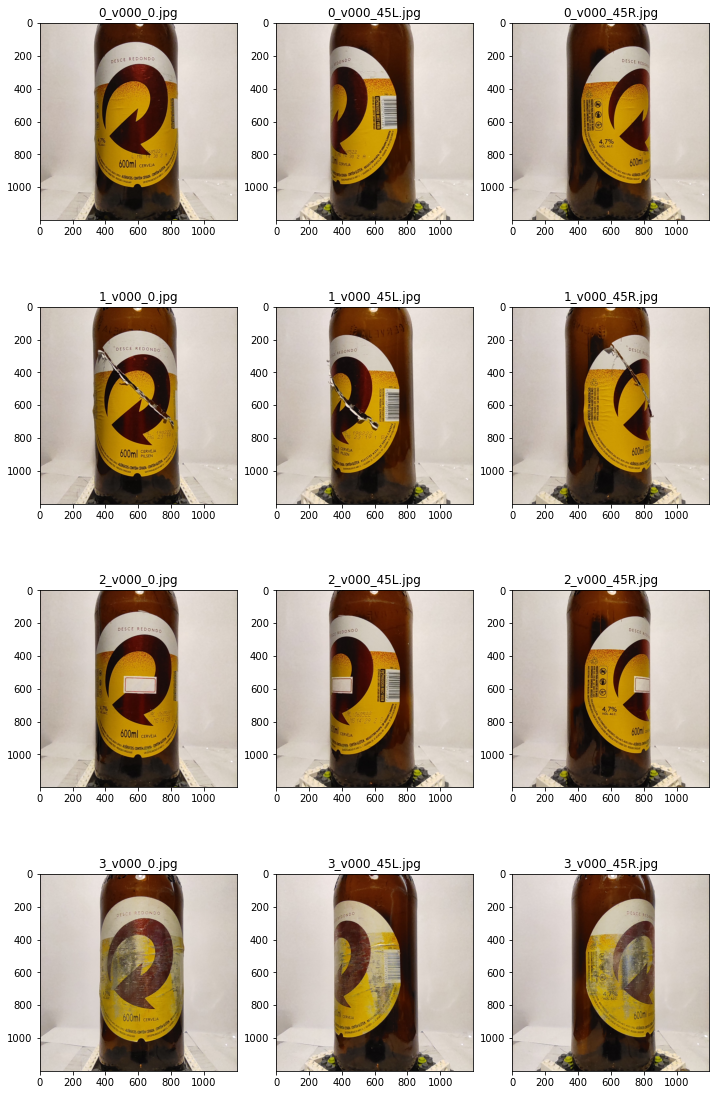

In [3]:
# exibindo algumas imagens dos conjuntos
query_imgs = []
query_labels = []
for i in range(3):
    query_imgs.append(plt.imread(bc.imgs[i]))
    query_labels.append(bc.labels[i])
query_idxs = [0, 1, 2]

train_imgs = [
    plt.imread(bc.imgs[240]), plt.imread(bc.imgs[241]), plt.imread(bc.imgs[242]),
    plt.imread(bc.imgs[360]), plt.imread(bc.imgs[361]), plt.imread(bc.imgs[362]),
    plt.imread(bc.imgs[480]), plt.imread(bc.imgs[481]), plt.imread(bc.imgs[482])
]
train_labels = [
    bc.labels[240], bc.labels[241], bc.labels[242],
    bc.labels[360], bc.labels[361], bc.labels[362],
    bc.labels[480], bc.labels[481], bc.labels[482]
]

fig, axs = plt.subplots(4, 3, figsize=(12, 20))
for i in range(3):
    axs[0, i].imshow(query_imgs[i])
    axs[0, i].set_title(query_labels[i])
for i in range(1, 4):
    for j in range(3):
        axs[i, j].imshow(train_imgs[(i - 1) * 3 + j])
        axs[i, j].set_title(train_labels[(i - 1) * 3 + j])
plt.show()

# Pré-Processamento

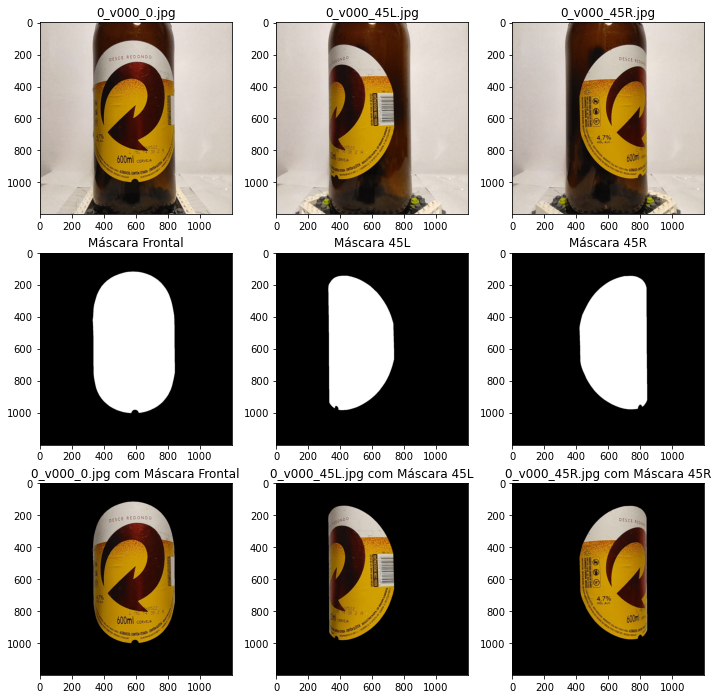

In [4]:
# Aplicação da máscara nas imagens do conjunto referência
masks = [
    plt.imread(join(PATH, 'mask0.jpg')),
    plt.imread(join(PATH, 'mask45L.jpg')),
    plt.imread(join(PATH, 'mask45R.jpg'))
]

query_imgs_m = []
for i in range(3):
    query_imgs_m.append(cv2.bitwise_and(query_imgs[i], masks[i]))

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
m = ['Máscara Frontal', 'Máscara 45L', 'Máscara 45R']
for i in range(3):
    axs[0, i].imshow(query_imgs[i])
    axs[0, i].set_title(query_labels[i])
    axs[1, i].imshow(masks[i])
    axs[1, i].set_title(m[i])
    axs[2, i].imshow(query_imgs_m[i])
    axs[2, i].set_title(f'{query_labels[i]} com {m[i]}')
plt.show()

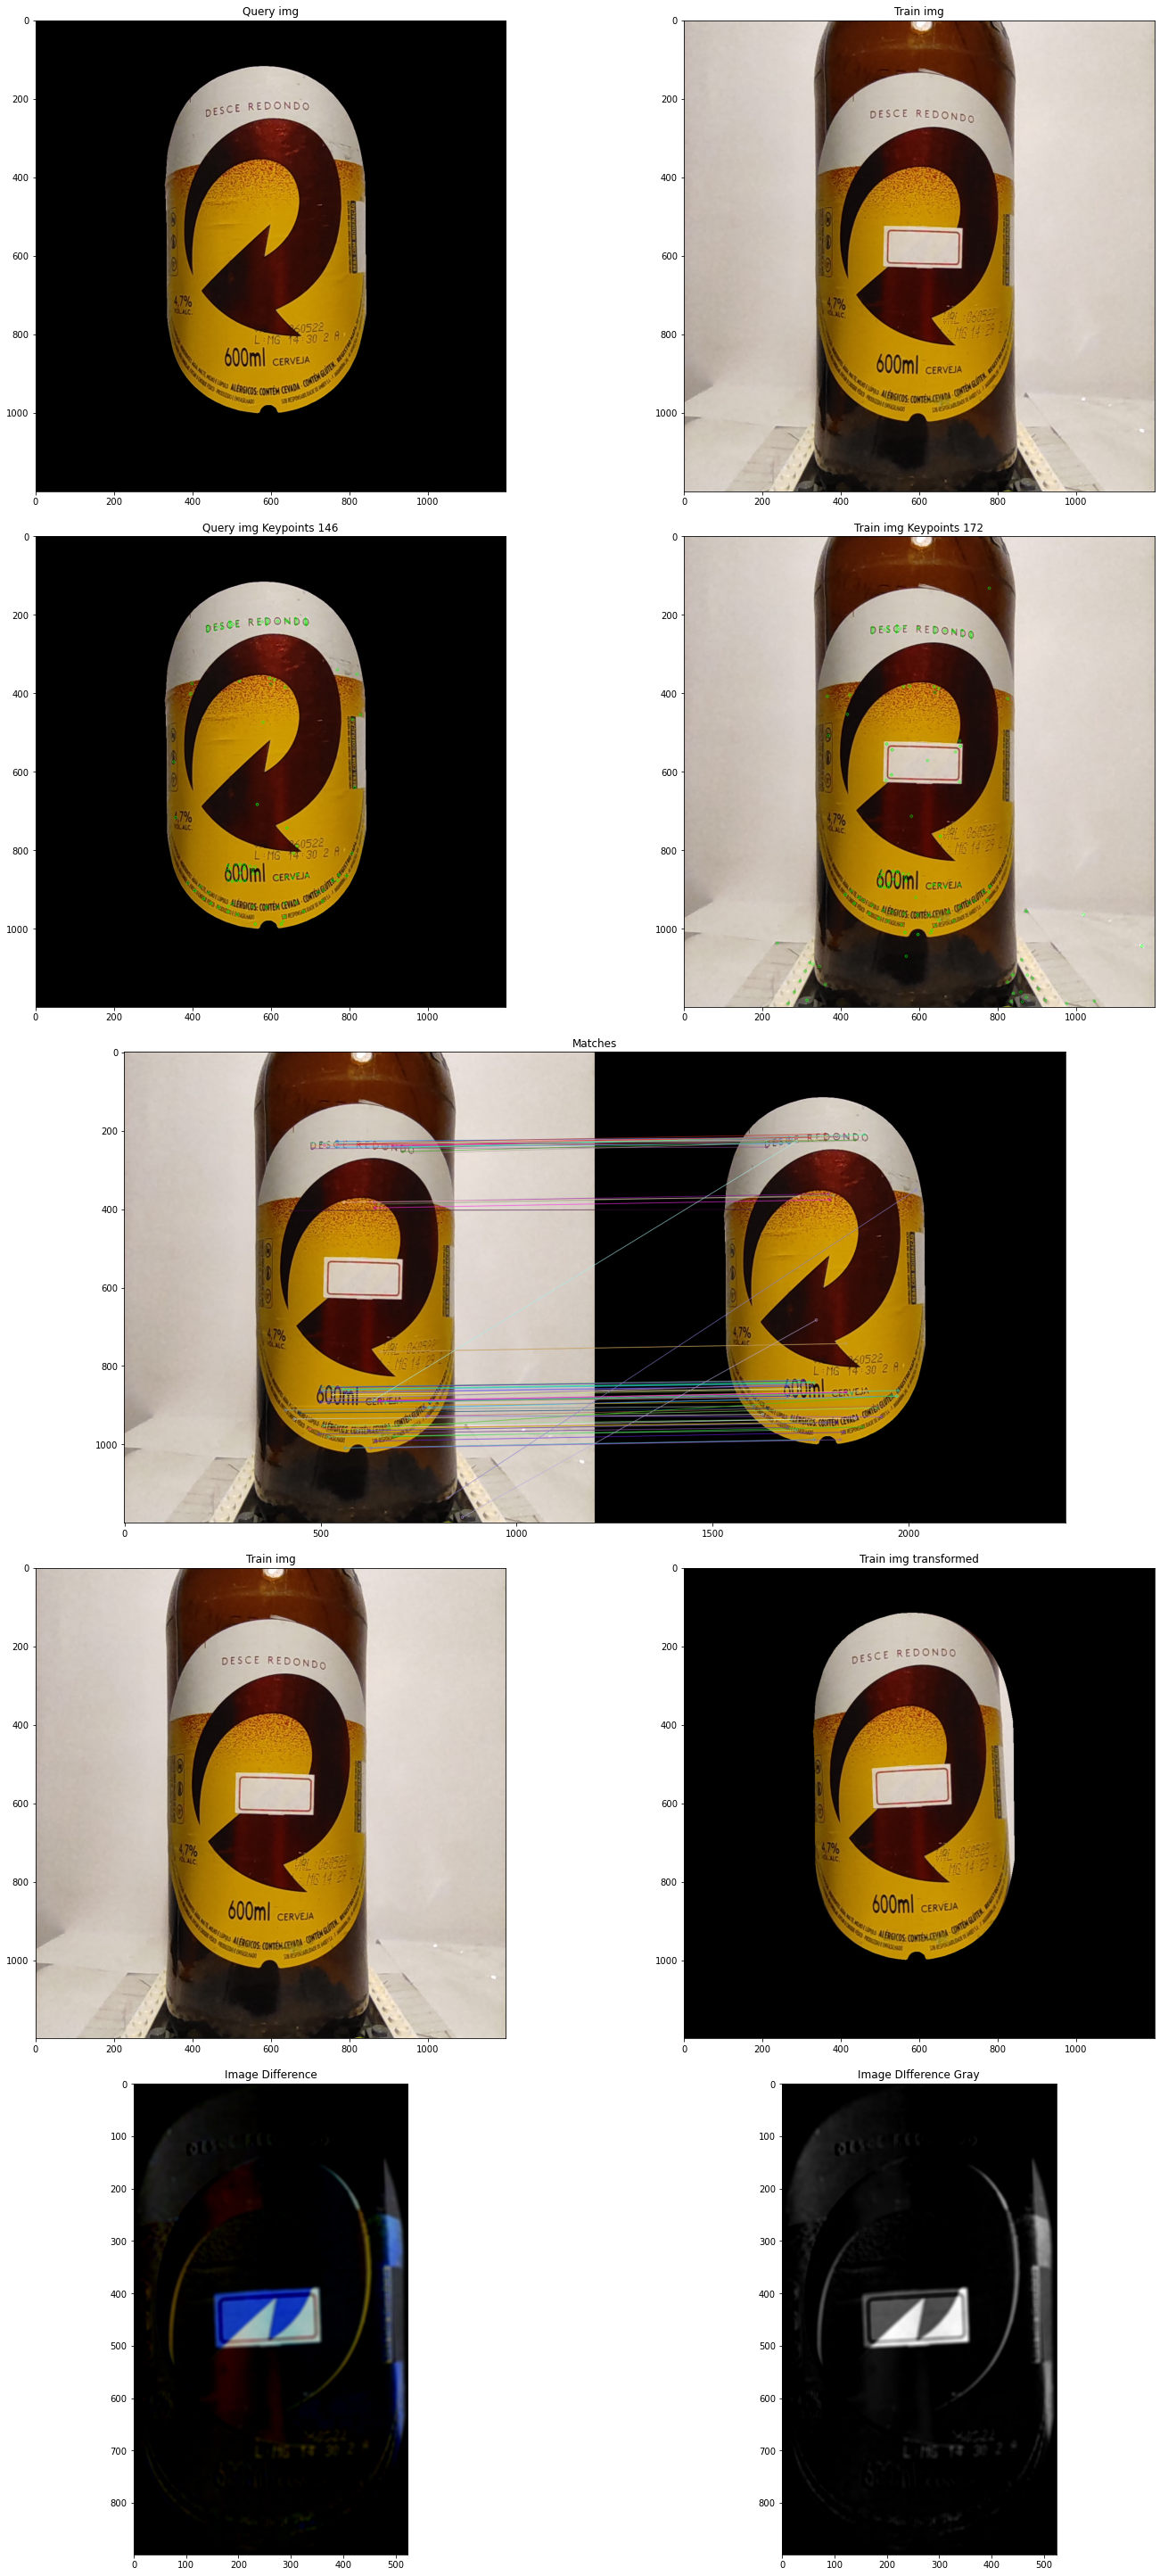

In [5]:
# exibe um exemplo de uma imagem diferença
img_diff = bc.processGetDiff(query_imgs_m[0], masks[0], train_imgs[3], plot=True)

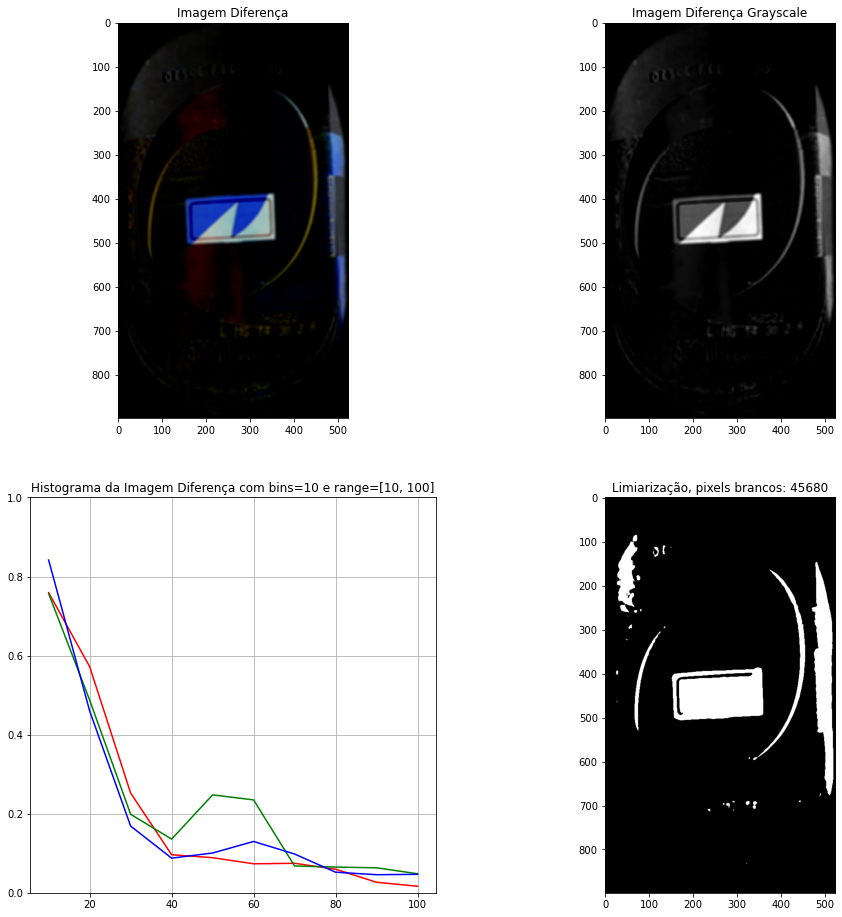

In [6]:
# exibe a imagem diferença com histograma e limiarização
img_diff_gray = cv2.cvtColor(img_diff, cv2.COLOR_RGB2GRAY)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
color = ('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img_diff], [i], None, [10], [10, 100])
    hist = cv2.normalize(hist, hist).flatten()
    axs[1, 0].plot(np.arange(10, 101, 10), hist, color=col)
    axs[1, 0].set_ylim(0.0, 1.0)
    axs[1, 0].grid()

_, img_diff_t = cv2.threshold(img_diff_gray, 25, 1, cv2.THRESH_BINARY)
t_sum = np.sum(img_diff_t)

axs[0, 0].imshow(img_diff)
axs[0, 0].set_title("Imagem Diferença")
axs[0, 1].imshow(img_diff_gray, 'gray')
axs[0, 1].set_title("Imagem Diferença Grayscale")
axs[1, 1].imshow(img_diff_t, 'gray')

axs[1, 1].set_title(f'Limiarização, pixels brancos: {t_sum}')
axs[1, 0].set_title("Histograma da Imagem Diferença com bins=10 e range=[10, 100]")
plt.show()

In [7]:
# crie uma pasta chamada "temp" dentro desse diretório para processar todas imagens diferenças 
# remova o comentário abaixo
# bc.processGetDiffAllImages(query_imgs_m, query_idxs, masks, 'temp')

Após obter todas as imagens diferenças, cria duas pastas, uma para imagens do conjunto de treinamento e outra para teste. Coloque metade das imagens diferenças obtidas do conjunto referência na pasta de treinamento. 

**OU descompacte os aquivos providenciados com as imagens já calculadas**

# Classificação
Realiza a classificação utilizando as _features_ da limiarização ou histograma com o classificador OneClassSVM ou IsolationForest.

Processo de _novelty detection_ utiliza um conjunto de treinamento livre de outliers.

Avalia a acurácia para diferentes conjuntos e no final a acuácia com todos os conjuntos.

Observe que a acurácia e erro esperado do treinamento deve ser a mesma para todos os exemplos do mesmo classificador uma vez que são treinados com o mesmo conjunto.

## Limiarização
Utilizando limiar T=25

In [8]:
# OneClassSVM
model = OneClassSVM(nu=0.15)
history = []
for i in ids:
    print(f'Testing images: [\'{i}\']')
    history.append(bc.thresholdAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=[i], T=25))
print(f'Id: {ids}')
history.append(bc.thresholdAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=ids, T=25))

Testing images: ['0']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 19/120 | 0.158    Acuracy: 0.842
Testing images: ['1']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 1/120 | 0.008    Acuracy: 0.992
Testing images: ['2']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 4/120 | 0.033    Acuracy: 0.967
Testing images: ['3']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 9/120 | 0.075    Acuracy: 0.925
Id: ['0', '1', '2', '3']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 29/480 | 0.060    Acuracy: 0.940


In [9]:
# IsolationForest
model = IsolationForest(contamination=0.15, random_state=42)
history = []
for i in ids:
    print(f'Testing images: [\'{i}\']')
    history.append(bc.thresholdAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=[i], T=25))
print(f'Id: {ids}')
history.append(bc.thresholdAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=ids, T=25))

Testing images: ['0']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 26/120 | 0.217    Acuracy: 0.783
Testing images: ['1']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 0/120 | 0.000    Acuracy: 1.000
Testing images: ['2']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 0/120 | 0.000    Acuracy: 1.000
Testing images: ['3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 2/120 | 0.017    Acuracy: 0.983
Id: ['0', '1', '2', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 29/480 | 0.060    Acuracy: 0.940


## Histograma

In [14]:
# OneClassSVM
# observou-se que OneClassSVM tente a obter piores resultados com o aumento 
# dos atributos, portanto o threshold nu deve ser maior para considerar mais erros
model = OneClassSVM(nu=0.5)
history = []
for i in ids:
    print(f'Testing images: [\'{i}\']')
    history.append(bc.compareHistogramAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=[i]))
print(f'Id: {ids}')
history.append(bc.compareHistogramAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=ids))

Testing images: ['0']
Train ->    Error: 59/117 | 0.504    Acuracy: 0.496
Test ->     Error: 60/120 | 0.500    Acuracy: 0.500
Testing images: ['1']
Train ->    Error: 59/117 | 0.504    Acuracy: 0.496
Test ->     Error: 3/120 | 0.025    Acuracy: 0.975
Testing images: ['2']
Train ->    Error: 59/117 | 0.504    Acuracy: 0.496
Test ->     Error: 1/120 | 0.008    Acuracy: 0.992
Testing images: ['3']
Train ->    Error: 59/117 | 0.504    Acuracy: 0.496
Test ->     Error: 0/120 | 0.000    Acuracy: 1.000
Id: ['0', '1', '2', '3']
Train ->    Error: 59/117 | 0.504    Acuracy: 0.496
Test ->     Error: 64/480 | 0.133    Acuracy: 0.867


In [11]:
# IsolationForest
model = IsolationForest(contamination=0.15, random_state=42)
history = []
for i in ids:
    print(f'Testing images: [\'{i}\']')
    history.append(bc.compareHistogramAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=[i]))
print(f'Id: {ids}')
history.append(bc.compareHistogramAllImages(model, 'diff_imgs\\train', 'diff_imgs\\test', test_ids=ids))

Testing images: ['0']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 19/120 | 0.158    Acuracy: 0.842
Testing images: ['1']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 0/120 | 0.000    Acuracy: 1.000
Testing images: ['2']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 0/120 | 0.000    Acuracy: 1.000
Testing images: ['3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 2/120 | 0.017    Acuracy: 0.983
Id: ['0', '1', '2', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 21/480 | 0.044    Acuracy: 0.956
